In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Playoff Team Predictor
## Custom Naive Bayes Functions

In [2]:
def p_x_given_class(obs_row, feature, class_,aggs):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]

    obs = obs_row[feature] #observation
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

def predict_class(obs_row,y_train,aggs,target_col=[0,1]):
    c_probs = []
    features_0 = {}
    features_1 = {}
    
    for i in range(len(target_col)):
        c = target_col[i]
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c,aggs)
        c_probs.append(p)
    
    return target_col[np.argmax(c_probs)]

def predict_class2(obs_row,y_train,aggs,target_col=[0,1]):
    c_probs = []
    features_0 = {}
    features_1 = {}
    
    for i in range(len(target_col)):
        c = target_col[i]
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c,aggs)
            if c == target_col[0]:
                features_0[feature]=p_x_given_class(obs_row, feature, c,aggs)
            elif c==target_col[1]:
                features_1[feature]=p_x_given_class(obs_row, feature, c,aggs)
        c_probs.append(p)
    
    return target_col[np.argmax(c_probs)] , features_0, features_1

def nba_stat_plot(bag,category,split_type):
    ind_cat=sorted(bag, key=bag.get,reverse =True)
    ind_val=sorted(bag.values(), reverse=True)
    stats = pd.DataFrame(list(zip(ind_cat,ind_val)),columns=['Stats','Count'])
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=stats['Stats'],y=stats['Count'],palette ="RdBu")
    ax.set_title(f'{category} Stat Indictors on {split_type} Data')

In [3]:
df = pd.read_csv('NBA_team_stats_2013to2019.csv',index_col=0)
print(len(df))
df.head()

209


,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,AST,STL,BLK,TOV,PF,PTS,Playoff,Location,Year,Conference
0,Nuggets,82,242.7,40.7,85.2,0.478,6.4,18.5,0.343,34.4,...,24.4,9.3,6.5,15.3,20.5,106.1,True,Denver,2013,Western
1,Rockets,82,241.2,38.1,82.7,0.461,10.6,28.9,0.366,27.5,...,23.2,8.3,4.4,16.4,20.3,106.0,True,Houston,2013,Western
2,Thunder,82,241.8,38.1,79.3,0.481,7.3,19.4,0.377,30.8,...,21.4,8.3,7.6,15.3,20.2,105.7,True,Oklahoma City,2013,Western
3,Spurs,82,242.4,39.1,81.4,0.481,8.1,21.5,0.376,31.1,...,25.1,8.5,5.4,14.7,17.4,103.0,True,San Antonio,2013,Western
4,Heat,82,242.4,38.4,77.4,0.496,8.7,22.1,0.396,29.6,...,23.0,8.7,5.4,13.9,18.7,102.9,True,Miami,2013,Eastern


In [4]:
X = df[[col for col in df.columns if col != 'Playoff' and col != 'Team' and 
        col != 'Location' and col != 'Conference' and col != 'G' and col != 'MP']]
y = df.Playoff
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=323)

In [5]:
train = pd.concat([X_train, y_train], axis=1)
aggs = train.groupby('Playoff').agg(['mean', 'std'])
aggs

FG                  FGA                 FG%            \
              mean       std       mean       std      mean       std   
Playoff                                                                 
False    38.124658  1.966227  85.268493  3.055727  0.447000  0.012652   
True     39.071084  2.053464  84.855422  3.097334  0.460482  0.015640   

               3P                  3PA            ...       BLK            \
             mean       std       mean       std  ...      mean       std   
Playoff                                           ...                       
False    8.426027  1.846997  24.256164  5.071379  ...  4.665753  0.677663   
True     9.537349  2.341967  26.240964  6.278691  ...  4.948193  0.818142   

               TOV                   PF                   PTS            \
              mean       std       mean       std        mean       std   
Playoff                                                                   
False    14.498630  1.264636  20.501370  1.520553  101.780822  5.639337   
True     14.019277  0.942681  20.156627  1.341295  105.330120  6.023141   

                Year            
                mean       std  
Playoff                         
False    2016.082192  1.941888  
True     2016.084337  1.976723  

[2 rows x 44 columns]

In [6]:
y_hat_train =[]
y_hat_test=[]
feat0_train=[]
feat1_train=[]
feat0_test=[]
feat1_test=[]
bag1_train={}
bag2_train={}
bag3_train={}
bag1_test={}
bag2_test={}
bag3_test={}

for i,idx in enumerate(range(len(X_train))):
    a,b,c=predict_class2(X_train.iloc[idx],y_train,aggs)
    y_hat_train.append(a)
    feat0_train.append(b)
    feat1_train.append(c)
    
    difference = {key: abs((feat0_train[i][key] - feat1_train[i].get(key,0)))/((feat0_train[i][key]+feat1_train[i].get(key,0))/2) for key in feat0_train[i].keys()}
    x=sorted(difference, key=difference.get,reverse =True)
    y=sorted(difference.values(), reverse=True)
    bag1_train[x[0]]=bag1_train.get(x[0],0)+1
    bag2_train[x[1]]=bag2_train.get(x[1],0)+1
    bag3_train[x[2]]=bag3_train.get(x[2],0)+1

for i,idx in enumerate(range(len(X_test))):
    a,b,c=predict_class2(X_test.iloc[idx],y_train,aggs)
    y_hat_test.append(a)
    feat0_test.append(b)
    feat1_test.append(c)
    
    difference = {key: abs((feat0_test[i][key] - feat1_test[i].get(key,0)))/((feat0_test[i][key]+feat1_test[i].get(key,0))/2) for key in feat0_test[i].keys()}
    x=sorted(difference, key=difference.get,reverse =True)
    y=sorted(difference.values(), reverse=True)
    bag1_test[x[0]]=bag1_test.get(x[0],0)+1
    bag2_test[x[1]]=bag2_test.get(x[1],0)+1
    bag3_test[x[2]]=bag3_test.get(x[2],0)+1   

#m, y_hat_train = [predict_class(X_train.iloc[idx],target_col) for idx in range(len(X_train))]
# y_hat_test = [predict_class(X_test.iloc[idx],target_col) for idx in range(len(X_test))]

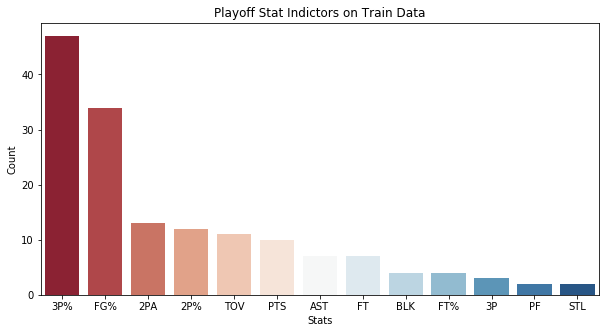

In [7]:
nba_stat_plot(bag1_train,'Playoff',"Train")

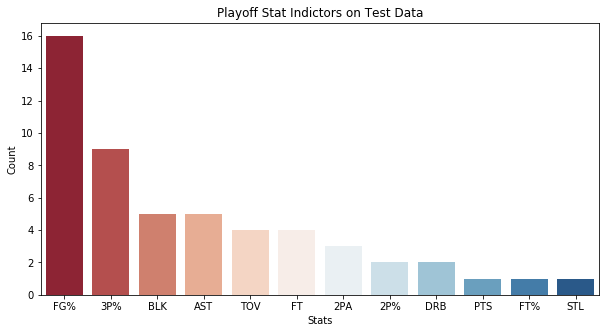

In [8]:
nba_stat_plot(bag1_test,'Playoff','Test')

In [9]:
residuals_train = y_hat_train == y_train
acc_train = residuals_train.sum()/len(residuals_train)

residuals_test = y_hat_test == y_test
acc_test = residuals_test.sum()/len(residuals_test)

print(f'Correct Train Predict: {residuals_train.sum()}\t Wrong Train Predict: {len(residuals_train)-residuals_train.sum()}')
print(f'Correct Test Predict: {residuals_test.sum()}\t Wrong Test Predict: {len(residuals_test)-residuals_test.sum()}')
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(acc_train, acc_test))

Correct Train Predict: 110	 Wrong Train Predict: 46
Correct Test Predict: 41	 Wrong Test Predict: 12
Training Accuracy: 0.7051282051282052	Testing Accuracy: 0.7735849056603774


## Gaussian Naive Bayes with Sklearn

In [10]:
model = GaussianNB()
y_train2 =y_train.astype(int)
y_test2 = y_test.astype(int)

model.fit(X_train, y_train2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [11]:
y_train_predict=model.predict(X_train)
y_test_predict2=model.predict(X_test)

In [12]:
print("Sklearn Train Accuracy:",metrics.accuracy_score(y_train2, y_train_predict))
print("Sklearn Test Accuracy:",metrics.accuracy_score(y_test2, y_test_predict2))

Sklearn Train Accuracy: 0.7051282051282052
Sklearn Test Accuracy: 0.7358490566037735


In [13]:
print('Sklearn Train ROC score: ',metrics.roc_auc_score(y_train2, y_train_predict))
print('Sklearn Test ROC score: ',metrics.roc_auc_score(y_test2, y_test_predict2))

Sklearn Train ROC score:  0.7096880673378445
Sklearn Test ROC score:  0.7298850574712644
